In [2]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from pymorphy2 import MorphAnalyzer
import re
from torch.autograd import Variable
import nltk
from pymorphy3 import MorphAnalyzer
from nltk.corpus import stopwords
from collections import defaultdict
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

In [3]:
patterns = "[«»A-Za-z0-9!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-]+"
stopwords_ru = stopwords.words("russian")
stopword = ["что", "я", "в", "и", "а", "но", "для", "не", "ни", "когда", "чтобы", "после", "он", "она", "оно",
                 "они", "потому", "нету", "вот", "без", "все", "этот", "тот", "то"]
morph = MorphAnalyzer()

In [4]:
df_csv = pd.read_csv(r"C:\Users\natal\lab_2_python\annotation1.csv")
texts = []
for absolute_path, rating in zip(df_csv['absolute_path'], df_csv['rating']):
    with open(absolute_path, 'r', encoding='utf-8') as file:
        text = file.read()
        texts.append((text, rating))
        
df = pd.DataFrame(texts, columns=['review', 'rating'])

In [5]:
df['rating'] = df['rating'].replace({1: 0, 2: 1, 3: 2, 4: 3, 5: 4})
print(df)

                                                 review  rating
0     Архимаг ищет невесту\nМного читала академок, р...       0
1     Манюня\nВсё, что нужно знать об уровне юмора э...       0
2     Удивительный Александр и крылатые кошки\nПочем...       0
3     Бездушный принц\nЗахотелось прочитать какую-ни...       0
4     Душа осьминога. Тайны сознания удивительного с...       0
...                                                 ...     ...
5000  Спаси меня от холода ночи\nЖизнь деревни Каслд...       4
5001  Витаминка\nКаково это быть купидоном? Это волш...       4
5002  Цветок в мужской академии магии\nХотела бы рас...       4
5003  Господин Неудача\nПосле загадочной гибели роди...       4
5004  Кай\n"Прежде чем войти куда-то, убедись, что т...       4

[5005 rows x 2 columns]


In [6]:
def lemmatize(review: str):
    review = re.sub(patterns, ' ', review)
    tokens = nltk.word_tokenize(review.lower())
    preprocessed_text = []
    for token in tokens:
        lemma = morph.parse(token)[0].normal_form
        if lemma not in stopwords_ru and lemma not in stopword:
            preprocessed_text.append(lemma)
    return preprocessed_text

In [7]:
df['review'] = df['review'].apply(lemmatize)
print(df.head())

                                              review  rating
0  [архимаг, искать, невеста, читать, академка, р...       0
1  [манюнить, всё, нужно, знать, уровень, юмор, к...       0
2  [удивительный, александр, крылатый, кошка, поч...       0
3  [бездушный, принц, захотеться, прочитать, нибы...       0
4  [душа, осьминог, тайна, сознание, удивительный...       0


In [8]:
def join_lemmatized_words(words_list):
    return ' '.join(words_list)

In [9]:
df['review'] = df['review'].apply(join_lemmatized_words)

In [64]:
vectorizer = CountVectorizer(max_features=40000)
sparse_matrix = vectorizer.fit_transform(df['review']).toarray()

x_train, x_test_valid, y_train, y_test_valid = train_test_split(sparse_matrix, np.array(df['rating']), test_size=0.2)
x_test, x_valid, y_test, y_valid = train_test_split(x_test_valid, y_test_valid, test_size=0.5)




In [65]:
unique, counts = np.unique(y_train, return_counts=True)
print(dict(zip(unique, counts)))

{0: 811, 1: 811, 2: 803, 3: 789, 4: 790}


In [66]:
class LogisticRegression(nn.Module):
    def __init__(self):
        super(LogisticRegression, self).__init__()
        self.linear1 = nn.Linear(40000, 400)
        self.linear2 = nn.Linear(400, 20)
        self.linear3 = nn.Linear(20, 5) 

    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return F.softmax(x, dim=1)


In [67]:
model = LogisticRegression()
criterion = nn.CrossEntropyLoss()
x_train = Variable(torch.from_numpy(x_train)).float()
y_train = Variable(torch.from_numpy(y_train)).long()
x_valid = Variable(torch.from_numpy(x_valid)).float()
y_valid = Variable(torch.from_numpy(y_valid)).long()
x_test = Variable(torch.from_numpy(x_train)).float()
y_test = Variable(torch.from_numpy(y_train)).long()

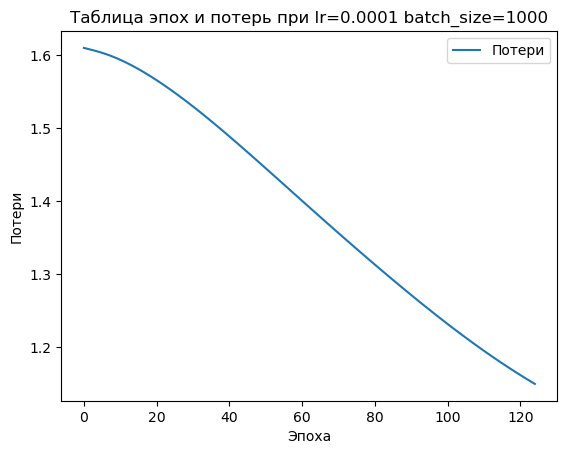

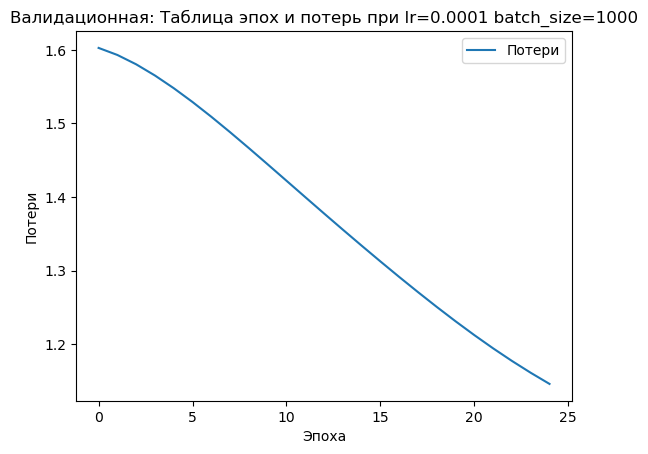

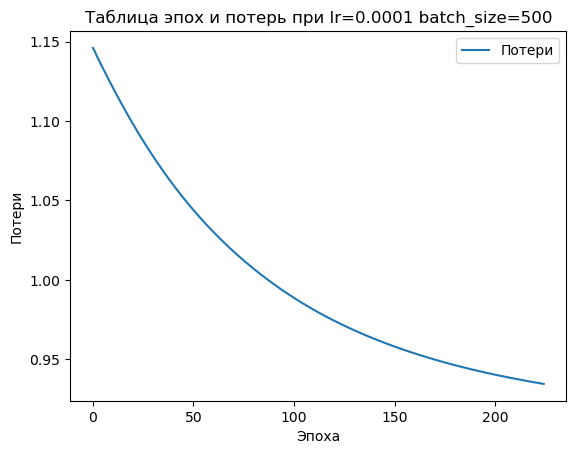

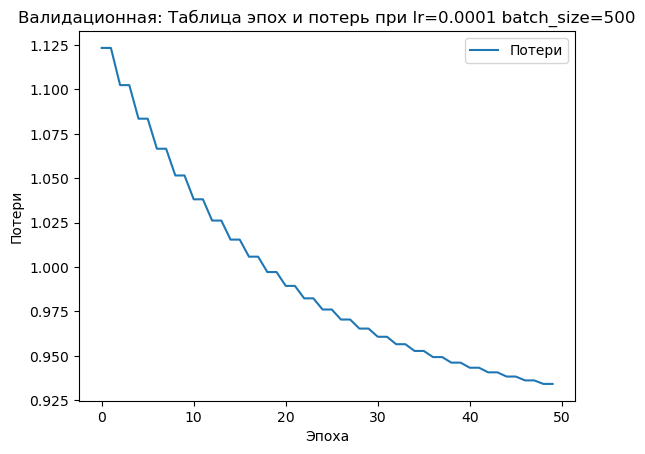

KeyboardInterrupt: 

In [24]:
lr_list = [0.0001,0.0002,0.0003]
batch_size=[1000, 500, 100]
for lr in lr_list:
  for bs in batch_size:
      data=torch.utils.data.DataLoader(x_train, batch_size=bs, shuffle=True)
      val_data = torch.utils.data.DataLoader(x_valid, batch_size=bs, shuffle=True)
      optimizer = torch.optim.Adam(params=model.parameters() , lr=lr)
      epochs = 25
      model.train()
      loss_ = []
      loss_val=[]
      for epoch in range(epochs):
       for elem in data:
        y_pred = model(x_train)
        loss = criterion(y_pred, y_train)
        loss_.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        pred = torch.max(y_pred, 1)[1].eq(y_train).sum()
        acc = pred * 100.0 / len(x_train)
       model.eval()
       for elem in val_data:
         y_pred = model(x_train)
         loss = criterion(y_pred, y_train)
         loss_val.append(loss.item())
         pred = torch.max(y_pred, 1)[1].eq(y_train).sum()
         acc = pred * 100.0 / len(x_train)
         
      plt.plot(loss_)
      plt.title('Таблица эпох и потерь при lr='+str(lr) +" batch_size="+str(bs))
      plt.xlabel('Эпоха')
      plt.ylabel('Потери')
      plt.legend(['Потери'])
      plt.show()


      plt.plot(loss_val)
      plt.title('Валидационная: Таблица эпох и потерь при lr='+str(lr) +" batch_size="+str(bs))
      plt.xlabel('Эпоха')
      plt.ylabel('Потери')
      plt.legend(['Потери'])
      plt.show()
 

In [68]:
epochs = 45
loss_values = []

model.train()
optimizer = torch.optim.Adam(params=model.parameters() , lr=0.0001)
for epoch in range(epochs):
    optimizer.zero_grad()
    y_pred = model(x_train)
    loss = criterion(y_pred, y_train)
    loss.backward()
    optimizer.step()
    loss_values.append(loss.item())

    pred = y_pred.data.max(1, keepdim=True)[1]
    correct = pred.eq(y_train.data.view_as(pred)).sum()
    accuracy = 100. * correct / len(x_train)

    print('Epoch: {}, Loss: {:.6f}, Accuracy: {}/{} ({:.2f}%)'.format(
        epoch, loss.item(), correct, len(x_train), accuracy))

Epoch: 0, Loss: 1.609519, Accuracy: 803/4004 (20.05%)
Epoch: 1, Loss: 1.608259, Accuracy: 810/4004 (20.23%)
Epoch: 2, Loss: 1.606995, Accuracy: 836/4004 (20.88%)
Epoch: 3, Loss: 1.605641, Accuracy: 884/4004 (22.08%)
Epoch: 4, Loss: 1.604160, Accuracy: 943/4004 (23.55%)
Epoch: 5, Loss: 1.602526, Accuracy: 1030/4004 (25.72%)
Epoch: 6, Loss: 1.600731, Accuracy: 1113/4004 (27.80%)
Epoch: 7, Loss: 1.598774, Accuracy: 1210/4004 (30.22%)
Epoch: 8, Loss: 1.596648, Accuracy: 1313/4004 (32.79%)
Epoch: 9, Loss: 1.594360, Accuracy: 1455/4004 (36.34%)
Epoch: 10, Loss: 1.591912, Accuracy: 1579/4004 (39.44%)
Epoch: 11, Loss: 1.589303, Accuracy: 1687/4004 (42.13%)
Epoch: 12, Loss: 1.586542, Accuracy: 1791/4004 (44.73%)
Epoch: 13, Loss: 1.583632, Accuracy: 1906/4004 (47.60%)
Epoch: 14, Loss: 1.580580, Accuracy: 2024/4004 (50.55%)
Epoch: 15, Loss: 1.577389, Accuracy: 2138/4004 (53.40%)
Epoch: 16, Loss: 1.574069, Accuracy: 2225/4004 (55.57%)
Epoch: 17, Loss: 1.570629, Accuracy: 2323/4004 (58.02%)
Epoch: 

In [69]:
model.eval()
with torch.no_grad():
    y_pred = model(x_test)
    loss = criterion(y_pred, y_test)
    pred = torch.max(y_pred, 1)[1].eq(y_test).sum()
    print ("Accuracy : {}%".format(100*pred/len(x_test)))

TypeError: linear(): argument 'input' (position 1) must be Tensor, not numpy.ndarray